<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Duffin_oscillator/Plots/Duffin_Oscillator_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#  Duffing oscillator process in a ball of $\mathbb{R}^2$ : visualization of trajectories and Monte Carlo estimation of MET

Based on the paper [A neural network solution of first-passage problems](https://link.springer.com/article/10.1007/s10483-024-3189-8) (Jiamin Qian, Lincong Chen & J. Q. Sun, Oct. 2024), the 2-dimensional Duffing oscillator is defined by:
$$ d \begin{pmatrix} X_1(t)\\
X_2(t) \end{pmatrix} = \begin{pmatrix} X_2\\
-X_1 - X_1^3 - 2\zeta X_2 \end{pmatrix} dt + \begin{pmatrix} \sqrt{2\varepsilon}dB_1(t)\\
\sqrt{2\zeta} dB_2(t) \end{pmatrix}$$

## 1) Visualization of the process:

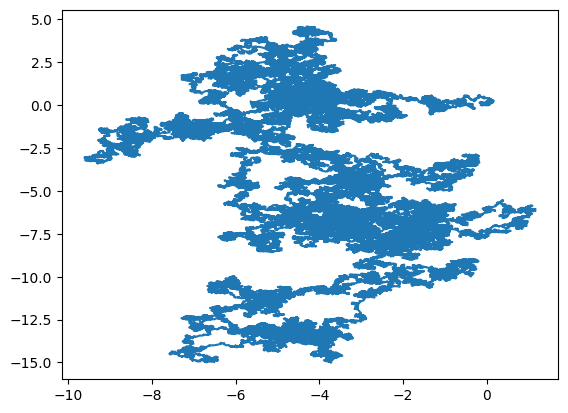

In [2]:
#parameters of simulation
bm_0 = np.zeros(2)
time_horizon = 100
dt = 10**-3
n_steps = int(time_horizon/dt)

# Brownian motion in a ball
bm = np.zeros((2,n_steps))
bm[:, 0] = bm_0

for k in range(1, n_steps):
    bm[:, k] = bm[:, k-1] + np.random.normal(scale=np.sqrt(dt), size=2)

#sanity check
plt.plot(bm[0], bm[1])

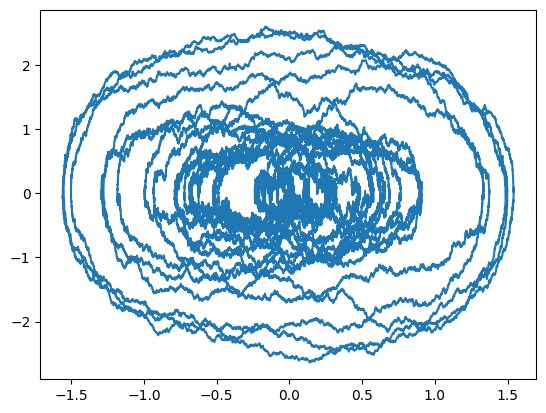

In [3]:
#Duffin-oscillator process

#parameters
do_0 = np.zeros(2)
zeta = 0.08
eps = 10**-5


do = np.zeros((2,n_steps))
do[:, 0] = do_0

for k in range(1, n_steps):
    scaled_b1 = np.sqrt(2*eps)*np.random.normal(scale=np.sqrt(dt))
    scaled_b2 = np.sqrt(2*zeta)*np.random.normal(scale=np.sqrt(dt))
    do[:, k] = do[:, k-1] \
              + dt*np.array([do[1,k-1], - do[0,k-1] - do[0,k-1]**3 - 2*zeta*do[1,k-1] ])\
              + np.array([scaled_b1, scaled_b2])

#sanity check
plt.plot(do[0], do[1])

In [4]:
#truncating the realizations outside the circle
radius = 2
do_norms = np.zeros(n_steps)
bm_norms = np.zeros(n_steps)

for k in range(1,n_steps):
    do_norms[k] = np.linalg.norm(do[:,k])
    bm_norms[k] = np.linalg.norm(bm[:,k])

do_exit = np.argmax(do_norms >= radius)
bm_exit = np.argmax(bm_norms >= radius)

if do_exit == 0:
    do_exit = n_steps

if bm_exit == 0:
    bm_exit = n_steps

trunc_do = np.zeros((2,do_exit))
trunc_bm = np.zeros((2,bm_exit))

trunc_do[:,:] = do[:,0:do_exit]
trunc_bm[:,:] = bm[:,0:bm_exit]

In [5]:
do_exit_time = do_exit * dt
bm_exit_time = bm_exit * dt

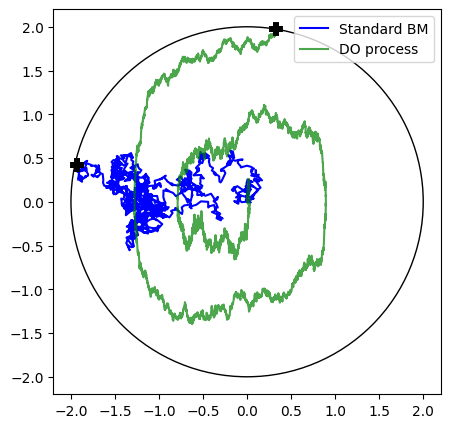

In [6]:
#plotting the brownian motion and Dufflin Oscillator process together

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(trunc_bm[0],trunc_bm[1], c='b', label = "Standard BM")
ax.plot(trunc_do[0], trunc_do[1], c='g', alpha=0.7, label = "DO process")
ax.plot(trunc_do[0,-1], trunc_do[1,-1], 'k+', mew=10, ms=5)
ax.plot(trunc_bm[0,-1], trunc_bm[1,-1], 'k+', mew=10, ms=5)
circle = plt.Circle((0,0),radius , fill = False)
ax.add_artist(circle)
ax.set_xlim([-1.1*radius, 1.1*radius])
ax.set_ylim([-1.1*radius, 1.1*radius])
ax.legend()
#plt.autoscale(False, tight=False)
plt.show()

In [7]:
print(f"BM exit time: {bm_exit_time}s, DO exit time: {do_exit_time}s.")

BM exit time: 1.264s, DO exit time: 8.825000000000001s.


## 2) Influence of the parameters on the MET

In [8]:
def duffin_oscillator(zeta, eps, radius, do_0, time_horizon, dt, exit=True):
    #initialization
    n_steps = int(time_horizon/dt)
    do = np.zeros((2,n_steps))
    do[:, 0] = do_0

    #generating the whole path
    for k in range(1, n_steps):
        scaled_b1 = np.sqrt(2*eps)*np.random.normal(scale=np.sqrt(dt))
        scaled_b2 = np.sqrt(2*zeta)*np.random.normal(scale=np.sqrt(dt))
        do[:, k] = do[:, k-1] \
                  + dt*np.array([do[1,k-1], - do[0,k-1] - do[0,k-1]**3 - 2*zeta*do[1,k-1] ])\
                  + np.array([scaled_b1, scaled_b2])

    #truncating the trajectory outside the circle
    do_norms = np.zeros(n_steps)
    for k in range(1,n_steps):
        do_norms[k] = np.linalg.norm(do[:,k])

    do_exit = np.argmax(do_norms >= radius)
    if do_exit == 0:
        do_exit = n_steps
        exit = False

    trunc_do = np.zeros((2,do_exit))
    trunc_do[:,:] = do[:,0:do_exit]

    return exit, trunc_do

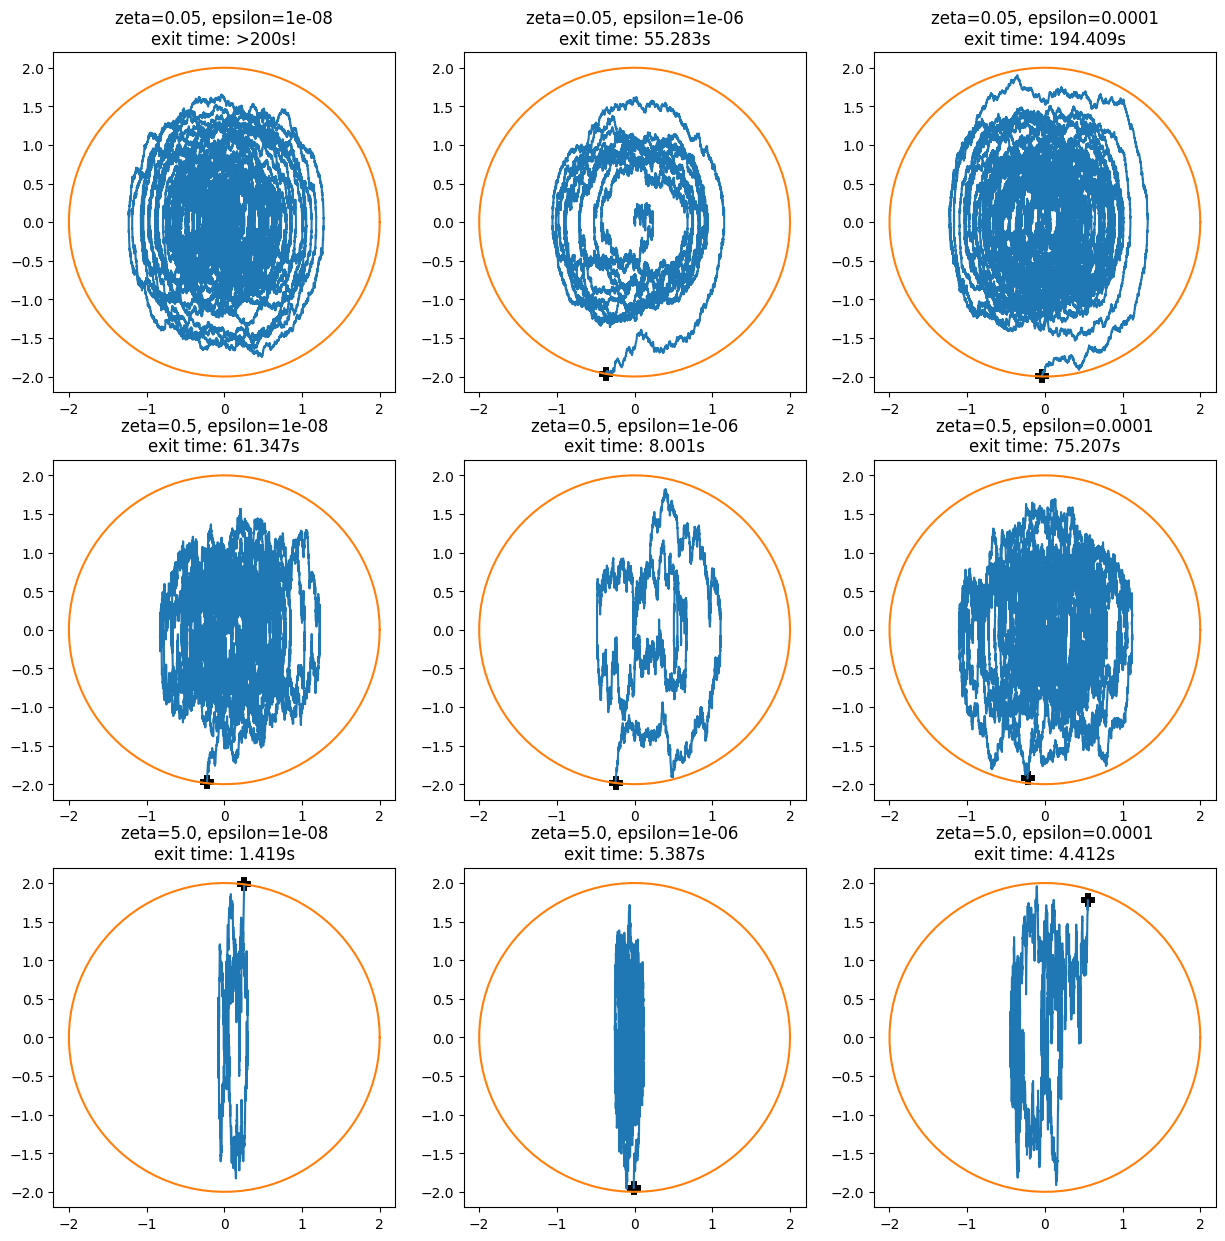

In [14]:
#choose a range of zeta eps
zetas = [0.05 * 10**k for k in range(3)]
epsis = [1e-8 * 10**(2*k) for k in range(3)]
n, m = len(zetas), len(epsis)

#parameters of the simulation
do_0 = np.zeros(2)
time_horizon = 200
dt = 10**-3
radius = 2

#plot a circle
theta = np.linspace(0, 2*np.pi, 100)
xs = radius*np.cos(theta)
ys = radius*np.sin(theta)

#plot
fig, axs = plt.subplots(n, m, figsize=(15, 15))
#fig.set_figheight(13)
#fig.set_figwidth(11)
for i in range(n):
    for j in range(m):
        exit_ij, do_ij = duffin_oscillator(zetas[i], epsis[j], radius, do_0, time_horizon, dt, exit=True)

        if exit_ij == True:
            axs[i,j].plot(do_ij[0,-1], do_ij[1,-1], 'k+', mew=10, ms=5)
            exit_message = f"exit time: {len(do_ij[0,:])*dt:.3f}s"
        else:
            exit_message = f"exit time: >{time_horizon}s!"

        axs[i,j].plot(do_ij[0], do_ij[1])
        axs[i,j].set_title(f"zeta={zetas[i]}, epsilon={epsis[j]}\n" + exit_message)
        axs[i,j].plot(xs,ys)
        #axs[i,j].axis('equal')
        axs[i,j].set_xlim([-1.1*radius, 1.1*radius])
        axs[i,j].set_ylim([-1.1*radius, 1.1*radius])

## 2) Monte Carlo computation of MET (FAIL)

A closed form solution for this problem is not tractable (?), hence we will estimate it with Monte Carlo methods

In [10]:
# n_mc = 100

# def do_monte_carlo_timer(x,y):

#     times = []

#     for k in range(n_mc):
#         do_1 = [x]
#         do_2 = [y]
#         current_norm = 0
#         current_steps = 1
#         while current_norm < r :
#             update_1 = do_2[-1]*dt
#             update_2 = -(do_1[-1] + do_1[-1]**3 + 2*zeta*do_2[-1])*dt  \
#                 + np.sqrt(2 * zeta) *np.random.normal(scale=np.sqrt(dt))
#             do_1.append(do_1[-1] + update_1)
#             do_2.append(do_2[-1] + update_2)
#             current_norm = np.linalg.norm((do_1[-1],do_2[-1]))
#             if current_steps >= max_steps - 1 :
#                 break
#             current_steps += 1
#         times.append(current_steps)
#     return dt * sum(times)/n_mc

# monte_carlo_solution = np.vectorize(do_monte_carlo_timer)

In [11]:
# #hyperparams
# zeta = 0.08
# r = 2
# dt = 10**-2
# max_steps = 50/dt

# #plotting the function
# n_points = 300
# tt = np.linspace(-1, 1, n_points) * r
# xx, yy = np.meshgrid(tt, tt)  # create unit square grid

# xx, yy = np.where(xx**2 + yy**2 <= r**2, xx, 0), np.where(xx**2 + yy**2 <= r**2 , yy, 0)
# zz = monte_carlo_solution(xx,yy)

In [12]:
# #circle
# a = np.linspace(0, 2*np.pi, 50)
# cx,cy = np.cos(a) * r , np.sin(a)*r

# fig, ax = plt.subplots()
# ax.plot(cx, cy,'k-', alpha=.2)

# contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
# ax.set_title("Monte Carlo solution estimate")
# cb = fig.colorbar(contour, ax=ax)

In [13]:
# #Duffin-oscillator process in same ball
# zeta = 0.08
# eps = 10**-5
# do_1 = [x_0[0]]
# do_2 = [x_0[1]]
# current_norm = 0
# current_steps = 1

# while current_norm < r :
#     update_1 = do_2[-1]*dt + np.sqrt(2*eps)*np.random.normal(scale=np.sqrt(dt))
#     update_2 = -(do_1[-1] + do_1[-1]**3 + 2*zeta*do_2[-1])*dt  \
#         + np.sqrt(2 * zeta) *np.random.normal(scale=np.sqrt(dt))
#     do_1.append(do_1[-1] + update_1)
#     do_2.append(do_2[-1] + update_2)
#     current_norm = np.linalg.norm((do_1[-1],do_2[-1]))
#     if current_steps >= max_steps - 1 :
#         break
#     current_steps += 1